### Prepare landcover input for discretization ###
Prepare landcover input data for the domain area. This step includes:<br>
1. project large-domain input into a common projection system.
2. extract input for the domain area.
3. resample input according to a reference raster (if needed).
4. classifiy landcover into canopy and non-canopy.
5. check domain landcover and landcover class.

In [1]:
# import libraries
import os
import geospatial_functions.geospatial_analysis as ga
import geospatial_functions.utils as ut
import rasterio as rio
import rasterio.shutil
from rasterio.warp import Resampling

In [2]:
# common paths
control_file = 'control_active.txt'
root_path = ut.read_from_control(control_file, 'root_path')
source_path = ut.read_from_control(control_file, 'source_path')
domain_name = ut.read_from_control(control_file, 'domain_name')
domain_path = os.path.join(root_path, domain_name)
plot_path = os.path.join(domain_path, 'plot')

In [3]:
# projection system
proj4=ut.read_from_control(control_file, 'proj4') 
dst_crs = rio.crs.CRS.from_string(proj4)

In [4]:
# large-domain data
landcover_raster = ut.read_from_control(control_file, 'landcover_raster')
landcover_prj_raster =  ut.read_from_control(control_file, 'landcover_prj_raster')
if landcover_prj_raster == 'default':
    landcover_prj_raster = os.path.join(source_path, os.path.basename(landcover_raster).split('.tif')[0]+'_prj.tif')

# domain data
domain_gru_prj_shp = ut.specify_file_path(control_file, 'domain_gru_prj_shp')
domain_extent = ut.specify_file_path(control_file, 'domain_extent')
domain_landcover_raster = ut.specify_file_path(control_file, 'domain_landcover_raster') 
domain_landcover_resample_raster = ut.specify_file_path(control_file, 'domain_landcover_resample_raster')
domain_landcover_class_raster = ut.specify_file_path(control_file, 'domain_landcover_class_raster')

#### 1. Project larage-domain landcover #### 

In [31]:
# ga.reproject_raster(landcover_raster, landcover_prj_raster, dst_crs, Resampling.nearest) 

#### 2. Extract domain landcover ####

In [5]:
ga.crop_raster(landcover_prj_raster, domain_gru_prj_shp, domain_landcover_raster) 

#### 3. Resample domain landcover ####
Resample is only applied to the domain raster that has a coarser resolution than the reference raster. The reference raster is specified by user (by default, it refers to the domain DEM).

In [6]:
refraster = ut.specify_refraster_path(control_file)
ga.resample_raster(domain_landcover_raster,refraster,domain_landcover_resample_raster) 

#### 4. Classify domain landcover into canopy and non-canopy ####
Here two classes were made: crop vs. non-crop.
Data source: 20-category International Geosphere - Biosphere Programme (IGBP) land cover dataset at 1/160 degree resolution (IGBP, 1990). 
Crop class includes: 0 Evergreen needleleaf forests, 1 Evergreen broadleaf forests, 2 Deciduous needleleaf forests, 3 Deciduous broadleaf forests, 4 Mixed forests, 6 Closed shrublands, 7 Woody savannas. 

In [13]:
ga.classify_landcover(domain_landcover_resample_raster, domain_landcover_class_raster)

#### 5a. Check domain landcover ####

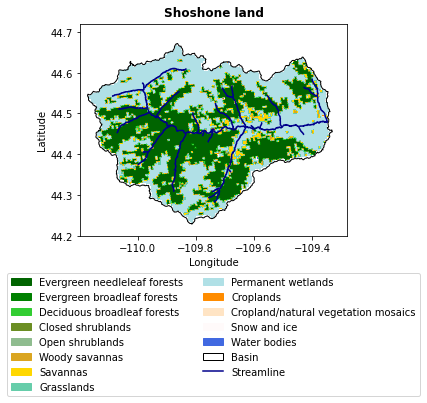

In [17]:
import geospatial_functions.geospatial_plot as gp
domain_stream_shp = ut.specify_file_path(control_file, 'domain_stream_shp')

wgs_crs = 'epsg:4326'
figsize=(9,9*0.6) # width, height in inches
title = domain_name.capitalize()+' land'
leg_ncol=2
leg_loc='upper center'
leg_bbox_to_anchor=(0.5,-0.15)
  
legend_dict={0:["darkgreen", "Evergreen needleleaf forests"],
             1:["green", "Evergreen broadleaf forests"],
             2:["forestgreen", 'Deciduous needleleaf forests'],
             3:["limegreen", 'Deciduous broadleaf forests'], 
             4:["lightgreen", 'Mixed forests'], 
             5:["olivedrab", 'Closed shrublands'], 
             6:["darkseagreen", 'Open shrublands'], 
             7:["goldenrod", 'Woody savannas'], 
             8:["gold", 'Savannas'], 
             9:["mediumaquamarine", 'Grasslands'], 
             10:["powderblue", 'Permanent wetlands'], 
             11:["darkorange", 'Croplands'], 
             12:["lightcoral", 'Urban and built-up lands'], 
             13:["bisque", 'Cropland/natural vegetation mosaics'], 
             14:["snow", 'Snow and ice'], 
             15:["grey", 'Barren'], 
             16:["royalblue", 'Water bodies']} 

# plot classified aspect
ofile = os.path.join(plot_path, 'land_and_bound_stream.png')   
inraster,bound_vector,stream_vector,wgs_crs,cmap_str,input_dict,figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile=\
domain_landcover_resample_raster,domain_gru_prj_shp,domain_stream_shp,wgs_crs,'user',legend_dict,figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile
gp.plot_raster_and_bound_stream(inraster,bound_vector,stream_vector,wgs_crs,cmap_str,input_dict,
                                figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile)

#### 5b. Check domain landcover class ####

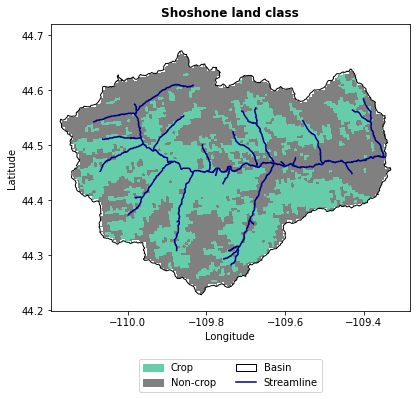

In [16]:
import geospatial_functions.geospatial_plot as gp
domain_stream_shp = ut.specify_file_path(control_file, 'domain_stream_shp')

wgs_crs = 'epsg:4326'
figsize=(9,9*0.6) # width, height in inches
title = domain_name.capitalize()+' land class'
leg_ncol=2
leg_loc='upper center'
leg_bbox_to_anchor=(0.5,-0.15)
  
legend_dict={1:["black", "Canopy"],
             2:["whitesmoke", "Non-canopy"]} 

# plot classified aspect
ofile = os.path.join(domain_path, 'plot', 'land_class_and_bound_stream.png')   
inraster,bound_vector,stream_vector,wgs_crs,cmap_str,input_dict,figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile=\
domain_landcover_class_raster,domain_gru_prj_shp,domain_stream_shp,wgs_crs,'user',legend_dict,figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile
gp.plot_raster_and_bound_stream(inraster,bound_vector,stream_vector,wgs_crs,cmap_str,input_dict,
                                figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile)